In [1]:
from collections import Counter
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords

import pandas as pd
import matplotlib.pyplot as plt
import string
import nltk
import spacy

data = pd.read_json('data/data.json')

### 1 - PIE CHARTS

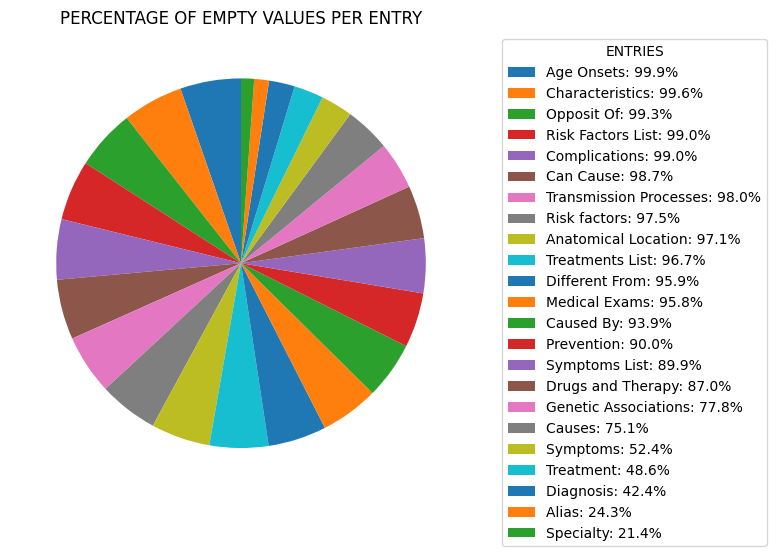

In [2]:
missing_percentages_per_entry = data.isnull().mean(axis=1) * 100
missing_percentages_per_entry = missing_percentages_per_entry[missing_percentages_per_entry > 0]

if missing_percentages_per_entry.empty:
    print("There is no empty spaces")
else:
    missing_percentages_per_entry = missing_percentages_per_entry.sort_values(ascending=False)
    plt.figure(figsize=(6, 6))
    wedges, texts = plt.pie(missing_percentages_per_entry, startangle=90)
    plt.title("PERCENTAGE OF EMPTY VALUES PER ENTRY")
    legend_labels = [f'{index}: {value:.1f}%' for index, value in zip(missing_percentages_per_entry.index, missing_percentages_per_entry)]
    plt.legend(legend_labels, title="ENTRIES", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()

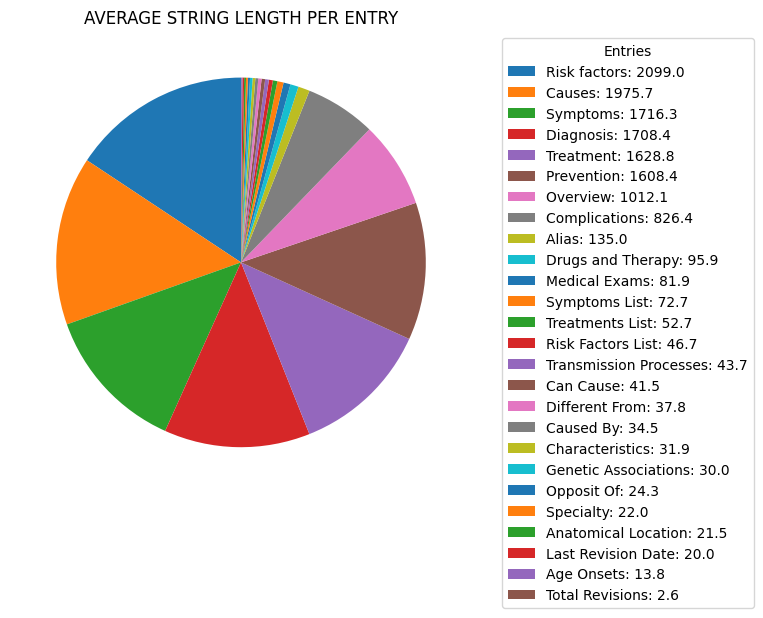

In [3]:
def mean_string_length(entry):
    strings = entry.dropna().astype(str)
    string_lengths = strings.apply(len)
    return string_lengths.mean()

mean_lengths_per_entry = data.apply(mean_string_length, axis=1)
mean_lengths_per_entry = mean_lengths_per_entry[mean_lengths_per_entry.notna()]

if mean_lengths_per_entry.empty:
    print("There are no valid string lengths in any entry.")
else:
    mean_lengths_per_entry = mean_lengths_per_entry.sort_values(ascending=False)
    plt.figure(figsize=(6, 6))
    wedges, texts = plt.pie(mean_lengths_per_entry, startangle=90)
    plt.title("AVERAGE STRING LENGTH PER ENTRY")
    legend_labels = [f'{index}: {value:.1f}' for index, value in zip(mean_lengths_per_entry.index, mean_lengths_per_entry)]
    plt.legend(legend_labels, title="Entries", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()


### 2 - 10 MOST COMMON

In [ ]:
entries = [
    ("Specialty","Specialty".upper()),                              # 0
    ("Symptoms List","Symptoms".upper()),                           # 1
    ("Medical Exams","Medical Exams".upper()),                      # 2
    ("Drugs and Therapy","Drugs and Therapy".upper()),              # 3
    ("Transmission Processes","Transmission Processes".upper()),    # 4
    ("Anatomical Location","Anatomical Location".upper()),          # 5
    ("Caused By","Causes".upper()),                                 # 6
    ("Can Cause","Effects".upper()),                                # 7
    ("Treatments List","Treatments".upper())]                       # 8

num_entries = len(entries)
cols = 2
rows = (num_entries + cols - 1) // cols

plt.figure(figsize=(14, 7 * rows))

for i, (entry,title) in enumerate(entries):
    if entry in data.index:
        all_words = []
        for col in data.columns:
            words = data.at[entry, col]
            if isinstance(words, list):
                all_words.extend(words)

        word_counts = Counter(all_words)
        most_common_words = word_counts.most_common(10)

        plt.subplot(rows, cols, i + 1)
        words, counts = zip(*most_common_words) if most_common_words else ([], [])
        plt.bar(words, counts, color='blue')
        plt.xticks(rotation=45, ha="right")
        plt.title(f"10 MOST COMMON {title}")
        plt.xlabel(f"{title}")
        plt.ylabel("NUMBER OF OCCURRENCES")

plt.tight_layout()
plt.show()

Through this graph it is possible to see that there are a large number of diseases whose Wikipedia page has already had several changes. With this information, we can predict that these diseases with the most reviews will be the most common, and the most frequently researched.

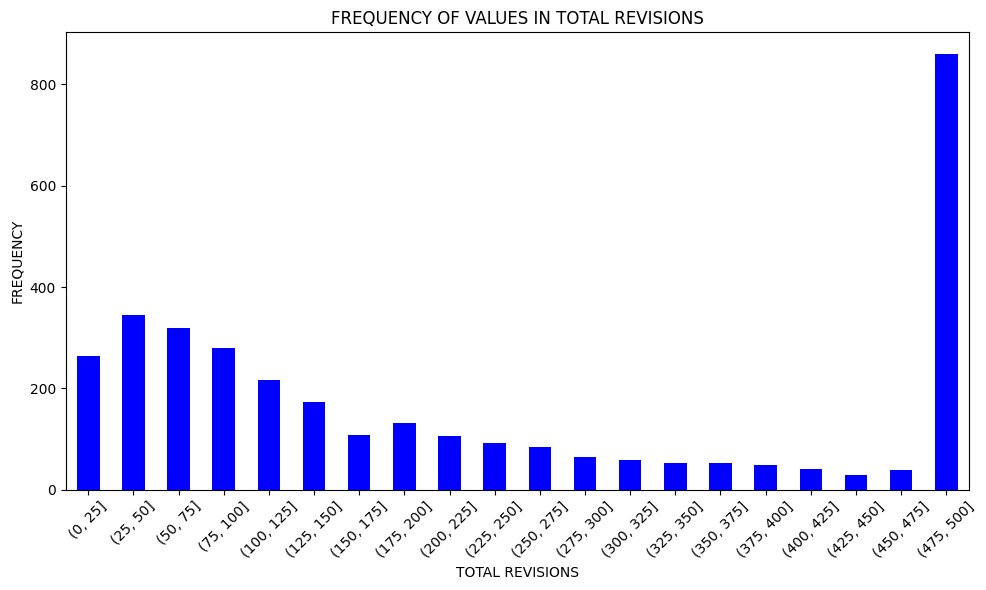

In [43]:

if "Total Revisions" in data.index:

    total_revisions = data.loc["Total Revisions"]
    bins = range(0, int(total_revisions.max()) + 25, 25)
    binned_revisions = pd.cut(total_revisions, bins=bins)
    value_counts = binned_revisions.value_counts().sort_index()

    plt.figure(figsize=(10, 6))
    value_counts.plot(kind='bar', color='blue')
    plt.title("FREQUENCY OF VALUES IN TOTAL REVISIONS")
    plt.xlabel("TOTAL REVISIONS")
    plt.ylabel("FREQUENCY")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


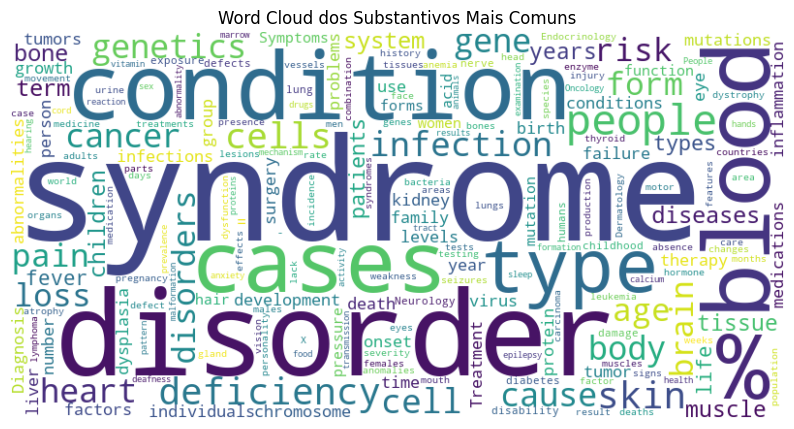

In [48]:
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')

personalized_list = [token.lower() for token in data.index]
personalized_list = personalized_list + ['disease','%','type']

def process_texts(texts):
    processed_nouns = []
    for doc in nlp.pipe(texts, batch_size=50, disable=["parser", "ner"]):
        nouns = [token.text for token in doc if token.pos_ == "NOUN" and token.text not in spacy.lang.en.stop_words.STOP_WORDS and token.text not in personalized_list]
        processed_nouns.extend(nouns)
    return processed_nouns

all_texts = []
for entry in data.index:
    for col in data.columns:
        content = data.at[entry, col]
        if isinstance(content, list):
            content = ' '.join(content)
        if isinstance(content, str):
            all_texts.append(content)

all_nouns = process_texts(all_texts)
noun_counts = Counter(all_nouns)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(noun_counts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("MOST COMMON WORDS")
plt.show()
